### **Student Information**  

Gideon Shachar  
204713689

Noy Rahmani  
311124416

In [19]:
# imports

from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt


data_folder = Path("./data")

In [20]:
# set matplotlib to show images nicely
%matplotlib inline
plt.rcParams['figure.figsize'] = (4, 4)

### Question 3 — Coin Detection in Mario Maps
#### You are given several Mario map images that contain multiple coins scattered in the scene. Your task is to detect these coins using template matching techniques.


1. **Smart Coin Cropping (Pre‑processing)**  
- Select one clear coin from the map.  
- Crop it smartly and manually (tight bounding box, centered, minimal background).  
- You may apply:  
    - Contrast enhancement  
    - Histogram equalization  
    - Smoothing or sharpening filters  
- Explain why your cropping is effective and how it improves template matching.


In [45]:
# load image
imname = "mario-bonusarea-a.png"
img = cv2.imread(data_folder / imname)

In [ ]:
# crop coin and save it (optional)
coin_roi = cv2.selectROI("Select Coin and press ENTER", img, False)
coin_img = img[coin_roi[1]:coin_roi[1]+coin_roi[3], coin_roi[0]: coin_roi[0]+coin_roi[2]]
cv2.destroyAllWindows()
cv2.imwrite(data_folder / 'coin.png', coin_img)

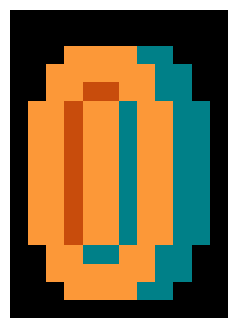

In [ ]:
# draw coin
coin_img = cv2.imread(data_folder / 'coin.png')
coin_img_rgb = cv2.cvtColor(coin_img, cv2.COLOR_BGR2RGB)
plt.imshow(coin_img_rgb)  
plt.axis('off')  
plt.show()

We choose not to apply histogram equalization or other image variations.  
Our coin image is an RGB image, so we don't want to harm the colors when applying histogram equalization.  
Morover, it has a good contrast and it is very detailed, so no variations needed.

2. **Template Matching Methods**  
Implement and test the following three similarity measures:  
- SAD — Sum of Absolute Differences  
- SSD — Sum of Squared Differences  
- ZNCC — Zero‑mean Normalized Cross‑Correlation  

For each method, you must:
- Apply it on each Mario map.  
- Detect all possible coin locations.  
- Mark the detected coins visually on the image (e.g., bounding box / circle).  
- Discuss positives and negatives of each method:  
    - Sensitivity to lighting
    - Sensitivity to contrast
    - When it fails and why

In [ ]:
# similarity measures

def sad(patch: np.ndarray, template: np.ndarray) -> float:
    patch_f = patch.astype(np.float32)
    template_f = template.astype(np.float32)
    return np.sum(np.abs(patch_f - template_f))


In [ ]:
def ssd(patch: np.ndarray, template: np.ndarray) -> float:
    patch_f = patch.astype(np.float32)
    template_f = template.astype(np.float32)
    diff = patch_f - template_f
    return np.sum(diff * diff)

In [ ]:
def zncc(patch: np.ndarray, template: np.ndarray) -> float:
    patch_f = patch.astype(np.float32)
    template_f = template.astype(np.float32)
    patch_zero = patch_f - patch_f.mean()
    template_zero = template_f - template_f.mean()
    num = np.sum(patch_zero * template_zero)
    denom = np.sqrt(np.sum(patch_zero ** 2) * np.sum(template_zero ** 2)) + 1e-8

    return num / denom

In [ ]:
def to_gray(img_bgr: np.ndarray) -> np.ndarray:
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    return gray.astype(np.float32)

In [ ]:
def compute_similarity_map(image_gray: np.ndarray,
                           template_gray: np.ndarray,
                           similarity_fn) -> np.ndarray:
    H, W = image_gray.shape
    h, w = template_gray.shape

    if h > H or w > W:
        raise ValueError("Template is larger than the image!")

    score_map = np.zeros((H - h + 1, W - w + 1), dtype=np.float32)

    for y in range(H - h + 1):
        for x in range(W - w + 1):
            patch = image_gray[y:y + h, x:x + w]
            score_map[y, x] = similarity_fn(patch, template_gray)

    return score_map

In [ ]:
imname = "mario-bonusarea-a.png"
img = cv2.imread(data_folder / imname)
coin_img = cv2.imread(data_folder / "coin.png")


SSD map shape: (208, 245)


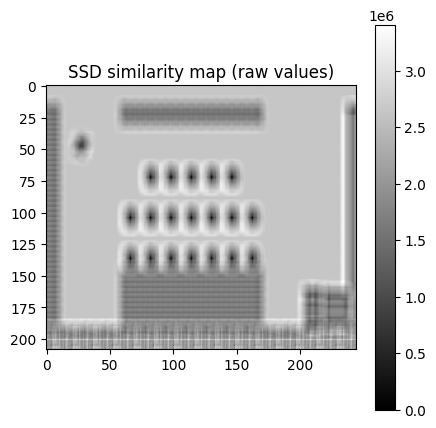

In [ ]:
img_gray = to_gray(img)
coin_gray = to_gray(coin_img)

ssd_map = compute_similarity_map(img_gray, coin_gray, ssd)

print("SSD map shape:", ssd_map.shape)

plt.figure(figsize=(5, 5))
plt.title("SSD similarity map (raw values)")
plt.imshow(ssd_map, cmap="gray")
plt.colorbar()
plt.show()


In [ ]:
def detect_coins_from_score_map(score_map: np.ndarray,
                                template_shape,
                                method: str = "ssd",
                                threshold_rel: float = 0.75,
                                max_detections: int = 200):
    h, w = template_shape

    if method.lower() in ("sad", "ssd"):
        response = -score_map
    elif method.lower() == "zncc":
        response = score_map
    else:
        raise ValueError(f"Unknown method: {method}")

    r_min, r_max = response.min(), response.max()
    response_norm = (response - r_min) / (r_max - r_min + 1e-8)

    H, W = response_norm.shape

    working = response_norm.copy()
    boxes = []

    while len(boxes) < max_detections:
        _, max_val, _, max_loc = cv2.minMaxLoc(working)
        if max_val < threshold_rel:
            break

        x, y = max_loc
        boxes.append((int(x), int(y)))

        x0 = max(0, x - w // 2)
        x1 = min(W, x + w // 2)
        y0 = max(0, y - h // 2)
        y1 = min(H, y + h // 2)

        working[y0:y1, x0:x1] = 0.0

    return boxes, response_norm


In [ ]:
def draw_detections(image_bgr: np.ndarray,
                    boxes,
                    template_shape,
                    color=(0, 0, 255),
                    thickness=2) -> np.ndarray:
    h, w = template_shape
    out = image_bgr.copy()
    for (x, y) in boxes:
        cv2.rectangle(out, (x, y), (x + w, y + h), color, thickness)
    return out


In [ ]:
def run_matching_on_map(
    imname: str,
    coin_img: np.ndarray,
    similarity_fn,
    method_name: str,
    threshold_rel: float = 0.75,
):
    img = cv2.imread(data_folder / imname)
    img_gray = to_gray(img)

    coin_gray = to_gray(coin_img)

    score_map = compute_similarity_map(img_gray, coin_gray, similarity_fn)

    boxes, response_norm = detect_coins_from_score_map(
        score_map,
        template_shape=coin_gray.shape,
        method=method_name,
        threshold_rel=threshold_rel,
    )

    vis = draw_detections(img, boxes, coin_gray.shape)

    return boxes, vis, response_norm


SSD detected 20 coins


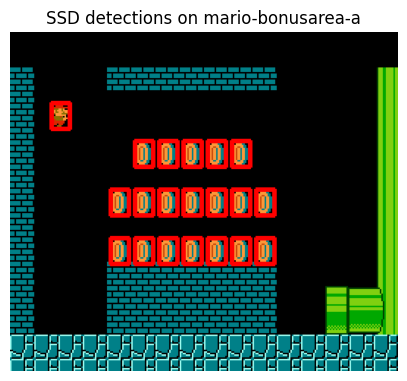

In [ ]:
coin_img = cv2.imread(data_folder / "coin.png")

boxes_ssd, vis_ssd, resp_ssd = run_matching_on_map(
    "mario-bonusarea-a.png",
    coin_img,
    similarity_fn=ssd,
    method_name="ssd",
    threshold_rel=0.75,
)

print(f"SSD detected {len(boxes_ssd)} coins")

plt.figure(figsize=(5, 5))
plt.title("SSD detections on mario-bonusarea-a")
plt.imshow(cv2.cvtColor(vis_ssd, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


SAD: detected 19 coins (threshold_rel = 0.75)


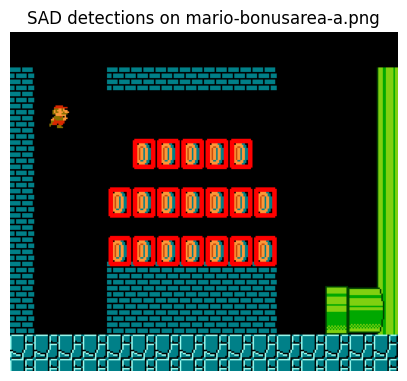

SSD: detected 20 coins (threshold_rel = 0.75)


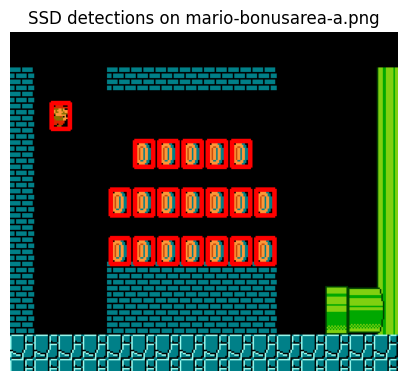

ZNCC: detected 19 coins (threshold_rel = 0.8)


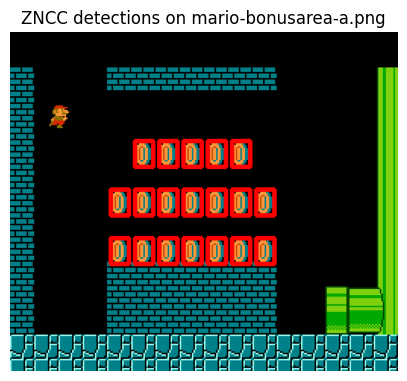

In [ ]:
# run all three similarity methods on a single map

coin_img = cv2.imread(data_folder / "coin.png")
map_name = "mario-bonusarea-a.png"

methods = [
    ("SAD",  sad,  "sad",  0.75),
    ("SSD",  ssd,  "ssd",  0.75),
    ("ZNCC", zncc, "zncc", 0.80),
]

results_per_method = {}

for label, fn, method_name, thr in methods:
    boxes, vis, resp = run_matching_on_map(
        map_name,
        coin_img,
        similarity_fn=fn,
        method_name=method_name,
        threshold_rel=thr,
    )

    results_per_method[label] = {
        "boxes": boxes,
        "response": resp,
    }

    print(f"{label}: detected {len(boxes)} coins (threshold_rel = {thr})")

    plt.figure(figsize=(5, 5))
    plt.title(f"{label} detections on {map_name}")
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


In [ ]:
from pathlib import Path

def get_mario_maps():
    map_paths = sorted(data_folder.glob("mario-*.png"))
    return [p.name for p in map_paths]

map_names = get_mario_maps()
print("Mario maps found:", map_names)


Mario maps found: ['mario-bonusarea-a.png', 'mario-bonusarea-b.png', 'mario-bonusarea-c.png', 'mario-bonusarea-d.png', 'mario-bonusarea-e.png', 'mario-bonusarea-f.png', 'mario-bonusarea-h.png', 'mario-bonusarea-i.png', 'mario-bonusarea-j.png', 'mario-bonusarea-k.png']


In [ ]:
def run_method_all_maps(
    method_label: str,
    similarity_fn,
    method_name: str,
    threshold_rel: float = 0.75,
):
    coin_img = cv2.imread(data_folder / "coin.png")
    map_names = get_mario_maps()

    results = {}

    for imname in map_names:
        print(f"\n=== {method_label} on {imname} ===")

        boxes, vis, resp = run_matching_on_map(
            imname,
            coin_img,
            similarity_fn=similarity_fn,
            method_name=method_name,
            threshold_rel=threshold_rel,
        )

        print(f"{method_label}: detected {len(boxes)} coins")

        results[imname] = {
            "boxes": boxes,
            "response": resp,
        }

        plt.figure(figsize=(5, 5))
        plt.title(f"{method_label} detections on {imname}")
        plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

    return results



=== SAD on mario-bonusarea-a.png ===
SAD: detected 19 coins


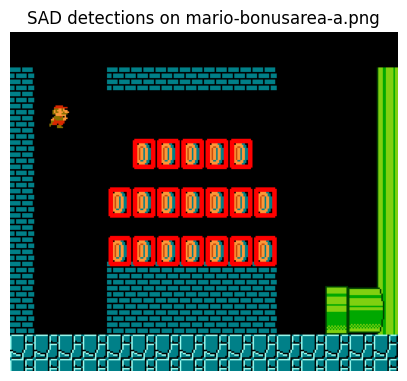


=== SAD on mario-bonusarea-b.png ===
SAD: detected 17 coins


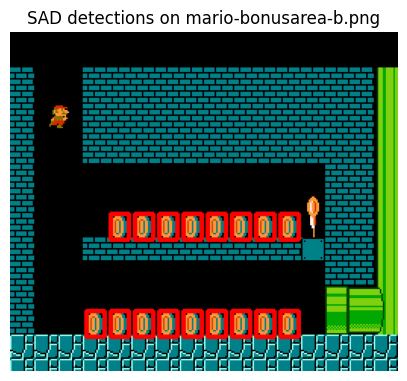


=== SAD on mario-bonusarea-c.png ===
SAD: detected 12 coins


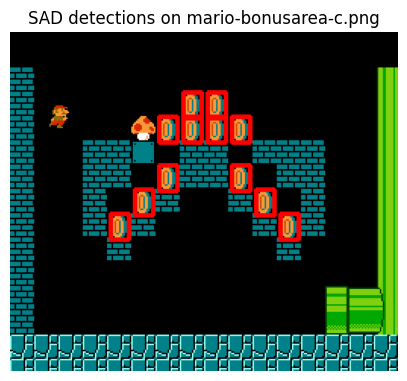


=== SAD on mario-bonusarea-d.png ===
SAD: detected 18 coins


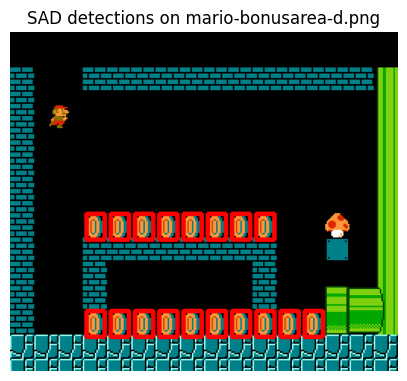


=== SAD on mario-bonusarea-e.png ===
SAD: detected 10 coins


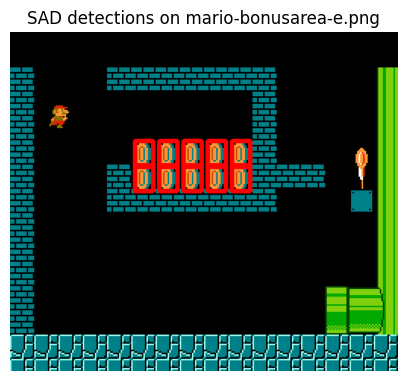


=== SAD on mario-bonusarea-f.png ===
SAD: detected 200 coins


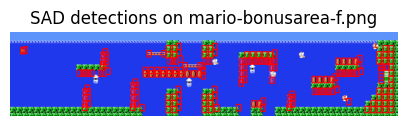


=== SAD on mario-bonusarea-h.png ===
SAD: detected 200 coins


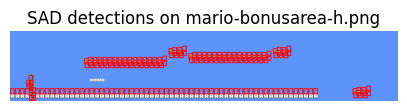


=== SAD on mario-bonusarea-i.png ===
SAD: detected 53 coins


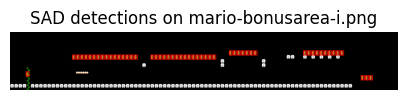


=== SAD on mario-bonusarea-j.png ===
SAD: detected 200 coins


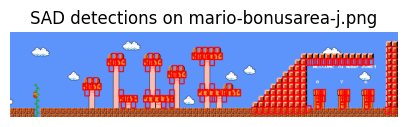


=== SAD on mario-bonusarea-k.png ===
SAD: detected 53 coins


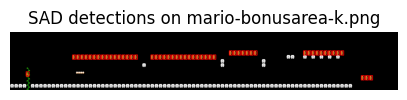

In [ ]:
sad_results = run_method_all_maps(
    method_label="SAD",
    similarity_fn=sad,
    method_name="sad",
    threshold_rel=0.75,   # you can tune after you see the results
)



=== SSD on mario-bonusarea-a.png ===
SSD: detected 19 coins


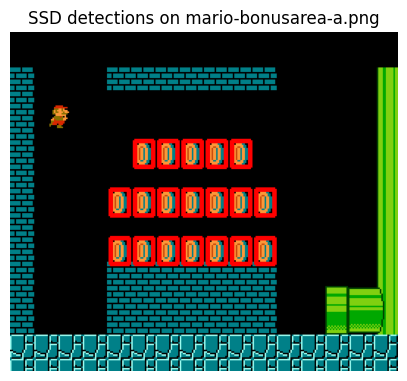


=== SSD on mario-bonusarea-b.png ===
SSD: detected 17 coins


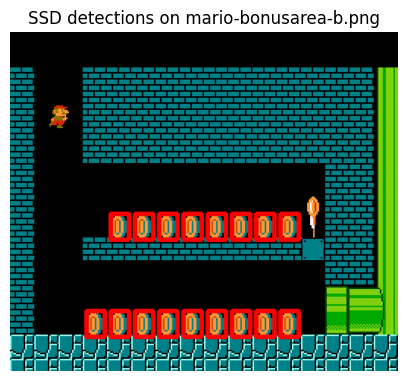


=== SSD on mario-bonusarea-c.png ===
SSD: detected 12 coins


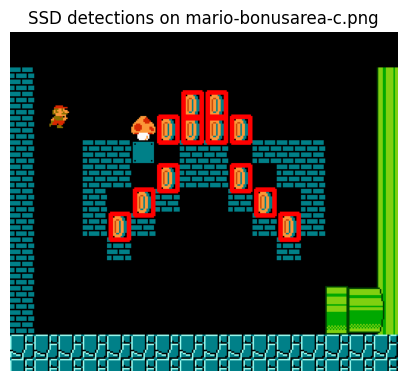


=== SSD on mario-bonusarea-d.png ===
SSD: detected 18 coins


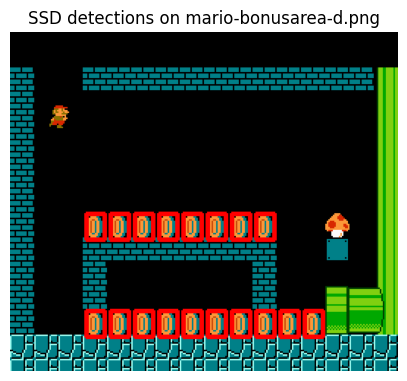


=== SSD on mario-bonusarea-e.png ===
SSD: detected 10 coins


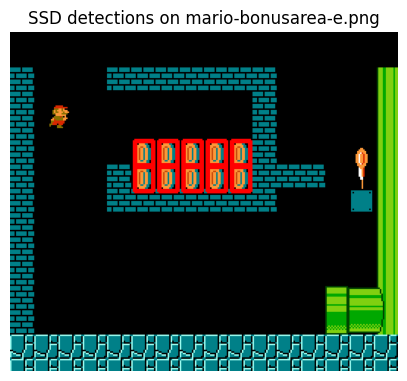


=== SSD on mario-bonusarea-f.png ===
SSD: detected 200 coins


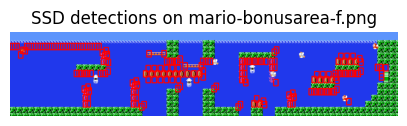


=== SSD on mario-bonusarea-h.png ===
SSD: detected 200 coins


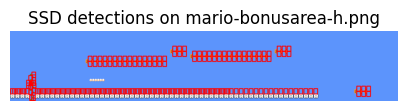


=== SSD on mario-bonusarea-i.png ===
SSD: detected 53 coins


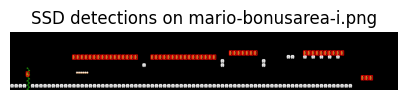


=== SSD on mario-bonusarea-j.png ===
SSD: detected 200 coins


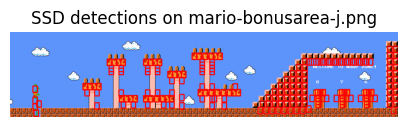


=== SSD on mario-bonusarea-k.png ===
SSD: detected 53 coins


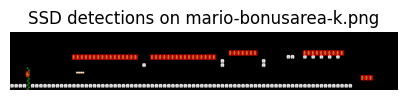

In [ ]:
ssd_results = run_method_all_maps(
    method_label="SSD",
    similarity_fn=ssd,
    method_name="ssd",
    threshold_rel=0.85,
)



=== ZNCC on mario-bonusarea-a.png ===
ZNCC: detected 19 coins


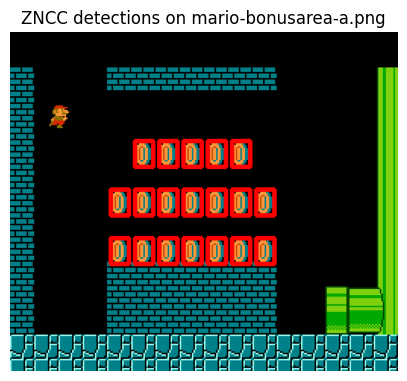


=== ZNCC on mario-bonusarea-b.png ===
ZNCC: detected 18 coins


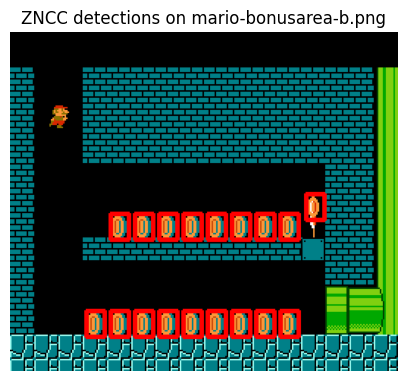


=== ZNCC on mario-bonusarea-c.png ===
ZNCC: detected 12 coins


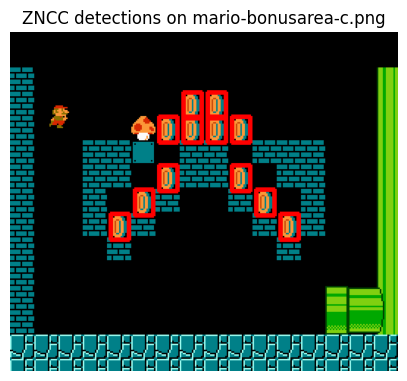


=== ZNCC on mario-bonusarea-d.png ===
ZNCC: detected 18 coins


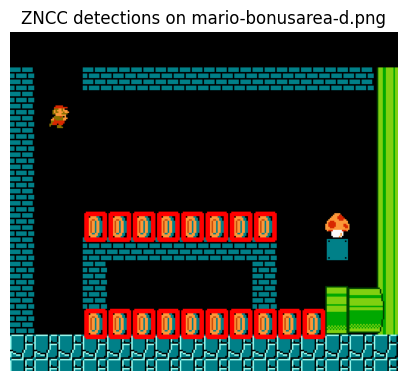


=== ZNCC on mario-bonusarea-e.png ===
ZNCC: detected 11 coins


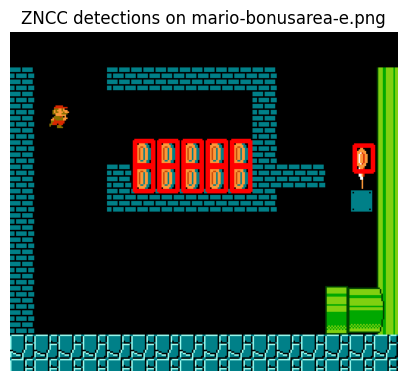


=== ZNCC on mario-bonusarea-f.png ===
ZNCC: detected 25 coins


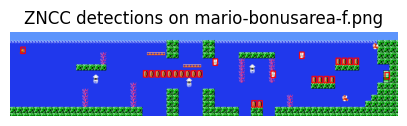


=== ZNCC on mario-bonusarea-h.png ===
ZNCC: detected 138 coins


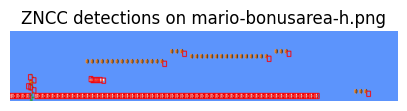


=== ZNCC on mario-bonusarea-i.png ===
ZNCC: detected 60 coins


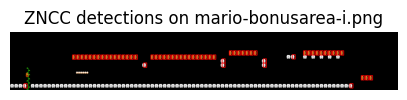


=== ZNCC on mario-bonusarea-j.png ===
ZNCC: detected 151 coins


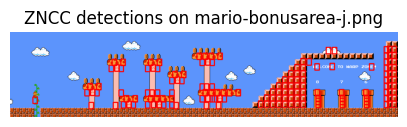


=== ZNCC on mario-bonusarea-k.png ===
ZNCC: detected 60 coins


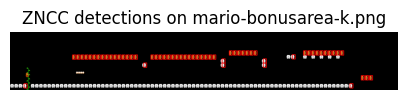

In [ ]:
zncc_results = run_method_all_maps(
    method_label="ZNCC",
    similarity_fn=zncc,
    method_name="zncc",
    threshold_rel=0.80,
)


**SAD – Sum of Absolute Differences**
- i. Sensitivity to lighting
    - If a map is brighter or darker than the template (additive change), all pixels shift by a constant so SAD becomes large even if the shape is identical.
    - In your maps: if one level has brighter red coins or lighter background than the template coin, SAD scores get worse and some true coins are missed unless you loosen the threshold a lot.

- ii. Sensitivity to contrast
    - If contrast changes (multiplying intensities), differences also change proportionally → SAD is not invariant to contrast.
    - A coin drawn with stronger highlights/shadows than the template will produce larger SAD, again hurting detection.

- iii. When it fails and why
    - Fails when global lighting/contrast differs between the template map (where you cropped the coin) and other maps.
    - Can also confuse background tiles that have similar average intensity: e.g. flat red areas or bricks with similar brightness as the coin.
    - Still, because it uses absolute value (not squared), it’s slightly more robust to outliers (e.g. a few noisy pixels) than SSD.

**SSD – Sum of Squared Differences**
- i. Sensitivity to lighting
- Same basic issue as SAD: any overall brightness change causes a bias in all pixels → SSD grows a lot.
    - Because of the square, brightness differences are penalized even more strongly than in SAD.
    - In your results this is visible on the big colorful maps: many patches that are “coin-like” in brightness get very similar SSD, so you end up with many high responses and need an aggressive NMS + threshold.
- ii. Sensitivity to contrast
    - Also not invariant to contrast. Stronger highlights/shadows or slightly thicker outlines on coins lead to much larger squared errors.
    - SSD is therefore quite sensitive to even small local intensity changes.
- iii. When it fails and why
    - Squaring makes SSD very sensitive to noise or small misalignment: a few mismatched pixels can dominate the sum.
    - On complex maps with a lot of red/orange tiles (like f, h, j), many background patterns have similar color to the coin, so SSD happily finds lots of false positives – you saw this as:
        - initially: tens of thousands of detections,
        - after greedy NMS: still hitting the max_detections cap (200) with some wrong boxes.
    - It works very well on the simple bonus rooms (black background, isolated coins) where lighting/contrast are consistent and the coin really is unique.

**ZNCC – Zero-mean Normalized Cross-Correlation**
- i. Sensitivity to lighting
    - Additive brightness changes (e.g. everything becomes 20 intensity units brighter) are largely canceled by subtracting the mean.
    - So if one map is overall brighter/darker than where you cropped the template, ZNCC is much more stable than SAD/SSD.
- ii. Sensitivity to contrast
    - Multiplicative contrast changes are largely handled by the division by standard deviation.
    - A coin that is drawn with slightly stronger contrast but the same shape will still give a high ZNCC value.
    - That’s why ZNCC typically gives more consistent scores across your different Mario maps where backgrounds and colors change a lot.
- iii. When it fails and why
    - If the patch has very low variance (almost flat area), the denominator is tiny. Even though we add 1e-8, the response can be unstable and random noise can produce high correlation → false positives in flat regions.
    - ZNCC focuses on the pattern of relative intensities, not the absolute color. So if there are other structures with similar “bright center / dark border” patterns (coins, pipes, some enemies), ZNCC may respond strongly to them too.
    - Also, ZNCC assumes a linear relationship between intensities. Non-linear changes (gamma, color shifts that don’t map well in grayscale) can still break it.

### Table: SAD — Coin Detection Results

| Map Name            | Total Coins (Ground Truth) | Detected | Missed | False Positives | Success Rate (%) |
|---------------------|----------------------------|----------|--------|-----------------|------------------|
| mario-bonusarea-a   |           19               |    19    |   0    |        0        |        100       |
| mario-bonusarea-b   |           18               |    17    |   1    |        0        |        94        |
| mario-bonusarea-c   |           12               |    12    |   0    |        0        |        100       |
| mario-bonusarea-d   |           18               |    18    |   0    |        0        |        100       |
| mario-bonusarea-e   |           11               |    10    |   1    |        0        |        90        |
| mario-bonusarea-f   |           20               |    200   |   0    |        180      |        1000      |
| mario-bonusarea-h   |           41               |    200   |   0    |        159      |        487       |
| mario-bonusarea-i   |           52               |    53    |   0    |        0        |        102       |
| mario-bonusarea-j   |           18               |    200   |   0    |        182      |        1111      |
| mario-bonusarea-k   |           43               |    53    |   0    |        10       |        123       |

### Table: SAD — Coin Detection Results

| Map Name            | Total Coins (Ground Truth) | Detected | Missed | False Positives | Success Rate (%) |
|---------------------|----------------------------|----------|--------|-----------------|------------------|
| mario-bonusarea-a   |           19               |    19    |   0    |        0        |        100       |
| mario-bonusarea-b   |           18               |    17    |   1    |        1        |        94        |
| mario-bonusarea-c   |           12               |    12    |   0    |        0        |        100       |
| mario-bonusarea-d   |           18               |    18    |   0    |        0        |        1000      |
| mario-bonusarea-e   |           11               |    10    |   1    |        1        |        90        |
| mario-bonusarea-f   |           20               |    200   |   0    |        180      |        1000      |
| mario-bonusarea-h   |           41               |    200   |   0    |        159      |        487       |
| mario-bonusarea-i   |           52               |    53    |   0    |        1        |        102       |
| mario-bonusarea-j   |           18               |    200   |   0    |        182      |        1111      |
| mario-bonusarea-k   |           43               |    53    |   0    |        10       |        123       |

### Table: SAD — Coin Detection Results

| Map Name            | Total Coins (Ground Truth) | Detected | Missed | False Positives | Success Rate (%) |
|---------------------|----------------------------|----------|--------|-----------------|------------------|
| mario-bonusarea-a   |           19               |    19    |   0    |        0        |        100       |
| mario-bonusarea-b   |           18               |    18    |   0    |        0        |        100       |
| mario-bonusarea-c   |           12               |    12    |   0    |        0        |        100       |
| mario-bonusarea-d   |           18               |    18    |   0    |        0        |        100       |
| mario-bonusarea-e   |           11               |    11    |   0    |        0        |        100       |
| mario-bonusarea-f   |           20               |    25    |   0    |        5        |        125       |
| mario-bonusarea-h   |           41               |    138   |   0    |        97       |        336       |
| mario-bonusarea-i   |           52               |    60    |   0    |        8        |        115       |
| mario-bonusarea-j   |           18               |    151   |   0    |        133      |        838       |
| mario-bonusarea-k   |           43               |    60    |   0    |        17       |        139       |